# Training flappy by combining BC and DQL

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gym
import numpy as np
import tf_layer

from flappyBird_env import FlappyBirdEnv
from flappyBird_cnn import FlappyBirdCnnEnv

from per.per import PER
import logging

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

(84, 84, 1)
Test [[0.4296875 0.4296875 0.4296875 ... 0.4296875 0.4296875 0.4296875]
 [0.4296875 0.4296875 0.4296875 ... 0.4296875 0.4296875 0.4296875]
 [0.4296875 0.4296875 0.4296875 ... 0.4296875 0.4296875 0.4296875]
 ...
 [0.4296875 0.4296875 0.4296875 ... 0.4296875 0.4296875 0.4296875]
 [0.4296875 0.4296875 0.4296875 ... 0.4296875 0.4296875 0.4296875]
 [0.4296875 0.4296875 0.4296875 ... 0.4296875 0.4296875 0.4296875]]


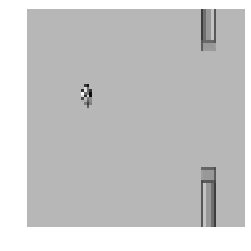

In [2]:
#env = FlappyBirdEnv()
env = FlappyBirdCnnEnv()
#env = make_atari('MsPacmanNoFrameskip-v4')
obs = env.reset()

print(obs.shape)

if isinstance(env, FlappyBirdCnnEnv):
    for i in range(20):
        _ = env.step(env.action_space.sample())

    im = np.reshape(env.state, (env.state.shape[0],env.state.shape[1]))

    print('Test', im)

    plt.figure(figsize=(4,4))
    plt.imshow(im, cmap='gray', vmin=-1., vmax=1.)
    plt.axis('off')
    plt.show()

In [4]:
def runGame(env, model):
    done = False
    obs = env.reset()
    R = 0
    while not done:
        #obs = np.expand_dims(obs,1)
        [action] = sess.run(model.predict, feed_dict={q_net.inputs:[obs]})
        obs, rew, done, info = env.step(action)
        R += rew
    return env.score, R


## **1. Deep Q Learning algorithm (DQN)**

### Experience Replay

In [5]:
class ExpReplay:
    def __init__(self, memory_size=5000, burn_in=1000):
        self.memory_size = memory_size
        self.burn_in = burn_in

    def burn_in_capacity(self):
        return len(self) / self.burn_in
        
class ExpReplayBuffer(ExpReplay):
    
    def __init__(self, memory_size=5000, burn_in=1000):
        ExpReplay.__init__(self, memory_size, burn_in)
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.Buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        batch = list(zip(*[self.replay_memory[i] for i in samples]))
        return [np.asarray(b) for b in batch]

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.Buffer(state, action, reward, done, next_state))
        
    def __len__(self):
        return len(self.replay_memory)
    
class PrioritizedExpReplay(ExpReplay):
    
    def __init__(self, memory_size=5000, burn_in=1000):
        ExpReplay.__init__(self, memory_size, burn_in)
        self.per = PER(self.memory_size)
        self.size = 0
        
    def sample_batch(self, batch_size=32):
        mini_batch, idxs, is_weights = self.per.sample(batch_size)
        batch = list(zip(*[i for i in mini_batch]))
        return [np.asarray(b) for b in batch]
        
    def append(self, priority, state, action, reward, done, next_state):
        self.per.add(priority, (state, action, reward, done, next_state))
        self.size+=1
        
    def __len__(self):
        return self.size

### Neural Network Architectures

In [6]:
class NeuralNetwork():
    def __init__(self, env, name='qnet'):
        self.name = name
        self.input_shape = list(env.observation_space.shape)
        self.output_shape = env.action_space.n
        
        self.inputs = tf.placeholder(tf.float32, shape=[None]+self.input_shape, name='{}-inputs'.format(name))
        self.q_out = self.propagation(self.inputs)
        self.predict = self.predict()
    
    def propagation(self, inputs, reuse=False):
        pass

    def predict(self):
        pass

class Q_Network(NeuralNetwork):
    
    def __init__(self, env, name='qnet'):
        NeuralNetwork.__init__(self, env, name=name)
        
    def propagation(self, inputs, reuse=False):
        outputs = tf.layers.dense(inputs, 128, activation='relu', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='{}_dense1'.format(self.name), reuse=reuse)
        outputs = tf.layers.dropout(outputs, rate=0.3)
        outputs = tf.layers.dense(inputs, 128, activation='relu', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='{}_dense2'.format(self.name), reuse=reuse)
        outputs = tf.layers.dropout(outputs, rate=0.3)
        outputs = tf.layers.dense(outputs, 64, activation='relu', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='{}_dense3'.format(self.name), reuse=reuse)
        outputs = tf.layers.dropout(outputs, rate=0.2)
        outputs = tf.layers.dense(outputs , self.output_shape,  name='{}_dense_out'.format(self.name), reuse=reuse)#, activation='sigmoid')
        return outputs
        
    def predict(self):
        return tf.argmax(self.q_out,1)
    
class Deep_Q_Network(NeuralNetwork):
    
    def __init__(self, input_shape, name='qnet'):
        NeuralNetwork.__init__(self, env, name=name)

        
    def propagation(self, inputs, reuse=False):
        conv1 = tf_layer.conv2d(inputs,)
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[8, 8], strides=(4,4), padding="same", name='{}_conv2d_1'.format(self.name), activation=tf.nn.relu, reuse=reuse)
        conv2 = tf.layers.conv2d(inputs=conv1, filters=64, kernel_size=[4, 4], strides=(2,2), padding="same", name='{}_conv2d_2'.format(self.name), activation=tf.nn.relu, reuse=reuse)
        conv3 = tf.layers.conv2d(inputs=conv2, filters=64, kernel_size=[3, 3], strides=(1,1), padding="same", name='{}_conv2d_3'.format(self.name), activation=tf.nn.relu, reuse=reuse)

        flat = tf.layers.flatten(conv3)
        fc1 = tf.layers.dense(flat, 512, name='{}_dense'.format(self.name), activation=tf.nn.relu, reuse=reuse)
        outputs = tf.layers.dense(fc1, self.output_shape, name='{}_dense_out'.format(self.name), reuse=reuse)
        return outputs
        
    def predict(self):
        return tf.argmax(self.q_out,1)

### Modèles

In [7]:
class DqnModel():
    
    def __init__(self, q_net, target_net, learning_rate = 0.001, batch_size=32, gamma=0.99, ddqn=True):
        self.q_net = q_net
        self.target_net = target_net
        
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='action')
        self.rewards = tf.placeholder(tf.float32, shape=(None,), name='reward')
        self.done_flags = tf.placeholder(tf.float32, shape=(None,), name='done')
        
        self.states = tf.placeholder(tf.float32, shape=[None]+self.q_net.input_shape, name='state')
        self.states_next = tf.placeholder(tf.float32, shape=[None]+self.q_net.input_shape, name='state_next')
    
        # Calcul for pred = Q_net(batch_states_t, batch_actions), 
        action_one_hot = tf.one_hot(self.actions, self.q_net.output_shape, 1.0, 0.0)
        self.pred = tf.reduce_sum(self.q_net.propagation(self.states, reuse=True) * action_one_hot, reduction_indices=-1)

        # Calcul for y = r_t + gamma * max_a ( Q_target(batch_states_t+1, a) )
        if ddqn:
            amax = tf.one_hot(tf.argmax(self.q_net.propagation(self.states_next, reuse=True), axis=-1), self.q_net.output_shape, 1.0, 0.0)
            max_Q_target = tf.reduce_sum(self.target_net.propagation(self.states_next, reuse=True) * amax, reduction_indices=-1)
        else:
            max_Q_target = tf.reduce_max(self.target_net.propagation(self.states_next, reuse=True))
        self.y = self.rewards + (1. - self.done_flags) * gamma * max_Q_target
        
        self.error = tf.reduce_mean(tf.abs(self.pred - self.y), name="error")
        
        # The loss measures the mean squared error between prediction and target.
        self.loss = tf.reduce_mean(tf.square(self.pred - tf.stop_gradient(self.y)), name="loss_mse_train")
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss, name="adam_optim")

### **Entrainement**

### Paramétrage

In [8]:
# Learning parameters
learning_rate = 0.001
gamma = .975

eps_debut=1.
eps = eps_debut
eps_fin= 0.05

num_max_step = 2000000
ttl_episode = 10000

# Buffer parameters
memory_size = 5000
learning_starts = 1000

# Other params
batch_size = 32
C = 1000
observation_shape = list(env.observation_space.shape)

print('Obs Shape =', observation_shape)

Obs Shape = [84, 84, 1]


In [24]:
# LOG Parameters 
freq_test = 30000
freq_log = 10000
freq_save_log = 1
freq_save = 50000
model_name = 'test-full-image'

restore_config={'restore': True,
                'step': 200000
               }

logging.basicConfig(filename='log/{}.log'.format(model_name), level=logging.INFO)

In [25]:
logging.info("Initialisation du modèle (Graph) ...")
tf.reset_default_graph()
exp_replay = PrioritizedExpReplay(memory_size=memory_size , burn_in=learning_starts)
graph = tf.Graph()
with graph.as_default():
    q_net = Deep_Q_Network(env, name='q-net')
    q_target = Deep_Q_Network(env, name='target-net')
    dqn_model = DqnModel(q_net, q_target, learning_rate=learning_rate, batch_size=batch_size,gamma=gamma)
    saver = tf.train.Saver(max_to_keep=2)
    t_vars = tf.trainable_variables()
    print(t_vars)

[<tf.Variable 'q-net_conv2d_1/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>, <tf.Variable 'q-net_conv2d_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'q-net_conv2d_2/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>, <tf.Variable 'q-net_conv2d_2/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'q-net_conv2d_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'q-net_conv2d_3/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'q-net_dense/kernel:0' shape=(7744, 512) dtype=float32_ref>, <tf.Variable 'q-net_dense/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'q-net_dense_out/kernel:0' shape=(512, 2) dtype=float32_ref>, <tf.Variable 'q-net_dense_out/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'target-net_conv2d_1/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>, <tf.Variable 'target-net_conv2d_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'target-net_conv2d_2/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>, <tf.Variable 'target-net_

In [ ]:
with tf.Session(graph=graph) as sess:
    # Initialisation du modèle
    if restore_config['restore']:
        list_loss = []
        list_rew = []
        list_value = []
        best_rew = 0
        global_step = 0
        sess.run(tf.global_variables_initializer())
    else:
        global_step = restore_config['step']
        saver.restore(sess, './models/{}-{}'.format(model_name, restore_config['step']))
    
    # Création d'un buffer initial
    logging.info("Initialisation du buffer d'Exp Replay ...")
    obs = env.reset()
    while exp_replay.burn_in_capacity() < 1:
        [action] = sess.run(q_net.predict, feed_dict={q_net.inputs:[obs]})
        obs1, reward, done, _ = env.step(action)
        
        error = sess.run(dqn_model.error, feed_dict={dqn_model.states:[obs],
                                                     dqn_model.states_next:[obs1], 
                                                     dqn_model.actions:[action], 
                                                     dqn_model.rewards:[reward],
                                                     dqn_model.done_flags:[done]})
        exp_replay.append(error, obs, action, reward, done, obs1)
        obs = obs1
    
    logging.info("Start learning ...")
    while global_step < num_max_step:
        obs = env.reset()
        local_step=0
        while (local_step<ttl_episode):
            # Select action
            if np.random.rand() < eps:
                action = env.action_space.sample()
            else :
                [action] = sess.run(q_net.predict, feed_dict={q_net.inputs:[obs]})
            
            [q_value] = sess.run(q_net.q_out, feed_dict={q_net.inputs:[obs]})
            
            # Execute action and observe reward
            obs1, reward, done, _ = env.step(action)
            
            # Store transition
            error = sess.run(dqn_model.error, feed_dict={dqn_model.states:[obs], dqn_model.states_next:[obs1], 
                                                         dqn_model.actions:[action],dqn_model.rewards:[reward],
                                                         dqn_model.done_flags:[done]})
            
            exp_replay.append(error, obs, action, reward, done, obs1)
            obs = obs1
                        
            # Sample random mini-batch from replay buffer
            observs, actions, rewards, done_flags, observs1 = exp_replay.sample_batch(batch_size)
            
            # Process update of the model
            loss, _ = sess.run([dqn_model.loss, dqn_model.optimizer],feed_dict={dqn_model.states:observs, dqn_model.states_next:observs1, 
                                                                                dqn_model.actions:actions, dqn_model.rewards:rewards,
                                                                                dqn_model.done_flags:done_flags})
            
            # 
            eps = eps_debut - (global_step*((eps_debut-eps_fin)/num_max_step))
            if (global_step % freq_save_log == 0):
                list_loss.append(loss)
                list_value.append(sum(q_value))   
            
            # Update target_network
            if global_step % C==0:   
                t_vars = tf.trainable_variables()
            
                target_vars = [var for var in t_vars if q_target.name in var.name]
                net_vars = [var for var in t_vars if q_net.name in var.name]
    
                for i, var in enumerate(net_vars):
                    sess.run(target_vars[i].assign(var.eval()))
            
            if done:
                break

            # Log training
            if global_step % freq_log==0:
                logging.info("Exploration {:.1f}%".format(eps*100))
                logging.info("Step {}/{} -- Loss = {:.6f} -- Value = {:.2f}".format(global_step, num_max_step, loss, sum(q_value)))
                
            # Save current model
            if global_step % freq_save == 0 :
                eval_display_policy(sess, FlappyBirdCnnEnv, global_step, global_step//freq_save, save_name="{}-{}".format(model_name, global_step))
                logging.info("Saving model step {}".format(global_step))
                saver.save(sess, "./models/{}".format(model_name), global_step=global_step)
            
            # Test current model
            if global_step % freq_test==0:
                rew = np.array([runGame(env, q_net)[1] for _ in range(5)])
                logging.info('Test Step {} -- Score={}, Mean={}'.format(local_step, rew , rew.mean()))
                list_rew.append(rew.mean())
                if rew.mean() > best_rew:
                    best_rew = rew.mean()
                    logging.info("New best model saved -> Mean rewards = {}".format(best_rew))
                    saver.save(sess, "./models/best-{}".format(model_name))
            
            global_step = global_step + 1 
            local_step = local_step + 1 
    
    logging.info("Learning finished")
    saver.save(sess, "./models/{}".format(model_name), global_step=global_step)   
    np.savez('log/{}.npz'.format(model_name), l_loss=list_loss, l_rew = list_rew, l_value=list_value)
    
    env.close()

In [13]:
print(len(list_rew))
print(len(list_value))
print(len(list_loss))
np.savez('log/{}.npz'.format(model_name), l_loss=list_loss, l_rew = list_rew, l_value=list_value)


4
1513
1513


### **Tests and Results**

In [1]:
def display_Q(x, v_0,v_1, title, num, save_name=None):
    fig, ax = plt.subplots()
    ax.plot(x, v_0, '-b', label='Q(s, a=0)')
    ax.plot(x, v_1, '-r', label='Q(s, a=1)')
    plt.xlabel('State')
    plt.ylabel('Q_value')
    plt.title('{}'.format(title))
    plt.grid()
    leg = ax.legend();
    fig.show()
    if save_name is not None :
        plt.savefig('plot_img/{}'.format(save_name))
    
def display_V(x, v, title, num, save_name=None):
    fig, ax = plt.subplots()
    ax.plot(x, v, '-b', label='V(s)')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.title('{}'.format(title))
    plt.grid()
    leg = ax.legend();
    fig.show()
    if save_name is not None :
        plt.savefig('plot_img/{}'.format(save_name))
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
def displayEnv(env, num):
    obs = np.reshape(env.state, (env.state.shape[0],env.state.shape[1]))
    f = plt.figure(num)
    plt.figure(figsize=(6,6))
    plt.imshow(obs, cmap='gray', vmin=-1., vmax=1.)
    plt.axis('on')
    plt.show()
    
def testValue(sess, q_net, env):
    v_0 = []
    v_1 = []
    dy = []
    for i in range(env.bird.rayon, env.height-env.bird.rayon):
        env.bird.y = i
        [action], [value] = sess.run([q_net.predict, q_net.q_out], feed_dict={q_net.inputs:[ env.state]})
        v_0.append(value[0])
        v_1.append(value[1])
        dy.append((env.bird.y + env.bird.rayon/2) - (env._get_current_plateform(env.bird).get_pos_ouv()+env._get_current_plateform(env.bird).get_size_ouv()/2))
    return dy, v_0, v_1

def get_np_log(file_name):
    log = np.load(file_name)
    return {'l_loss':log['l_loss'], 'l_rew':log['l_rew'], 'l_value':log['l_value']}

def eval_display_policy(sess, cls_env, num_model, num, save_name=None):
    import random
    env = cls_env()
    obs = env.reset()
    it=0
    while it < 90:
        it+=1
        obs, rew, done, info = env.step(random.randint(0,1))
    rew = np.array([runGame(env, q_net) for _ in range(10)])
    dy, v_0, v_1 = testValue(sess, q_net, env)
    mean_score, mean_rew = rew[:,0].mean(), rew[:,1].mean()
    display_V(dy, np.array(v_0)+np.array(v_1), 'Model after {} steps - Rew {:.2f}/Score {:.2f}'.format(num_model, mean_rew, mean_score), num+1, save_name=save_name)        
    display_Q(dy, v_0,v_1, 'Model after {} steps - Rew {:.2f}/Score {:.2f}'.format(num_model, mean_rew, mean_score), num+1, save_name=save_name)

[Text(0, 0.5, 'Value'), Text(0.5, 0, 'Steps')]

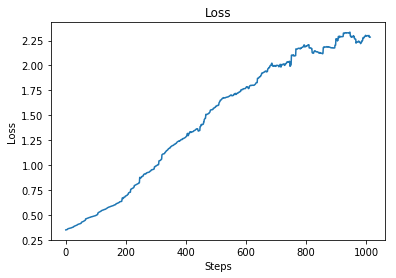

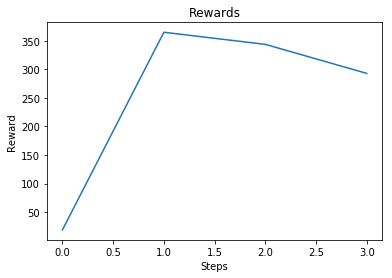

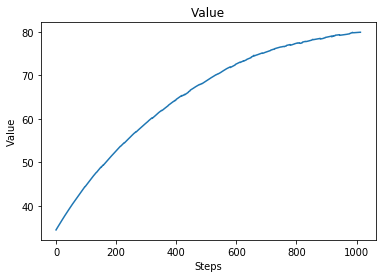

In [16]:
# Affiche déroulement de l'entrainement
file = 'log/{}.npz'.format(model_name)
dict_log = get_np_log(file)
l_loss, l_rew, l_value = dict_log['l_loss'],dict_log['l_rew'],dict_log['l_value']

mm_loss = moving_average(l_loss, 500)
fig, axs = plt.subplots()
axs.plot(mm_loss)
axs.set_title('Loss')
axs.set(xlabel='Steps', ylabel='Loss')

mm_rew = moving_average(l_rew, 1)
fig2, axs2 = plt.subplots()
axs2.plot(mm_rew)
axs2.set_title('Rewards')
axs2.set(xlabel='Steps', ylabel='Reward')

mm_value = moving_average(l_value, 500)
fig3, axs3 = plt.subplots()
axs3.plot(mm_value)
axs3.set_title('Value')
axs3.set(xlabel='Steps', ylabel='Value')

['l_rew_1', 'l_loss_1']
['l_rew_1', 'l_loss_1']


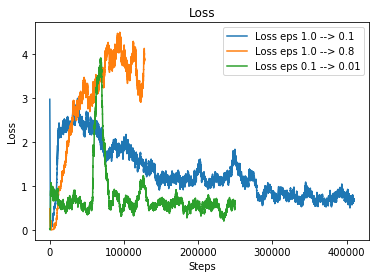

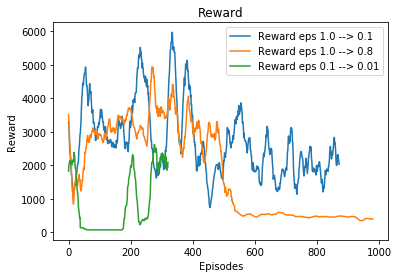

In [46]:
# Compare entraînements
test_comp = [
    get_np_log('log_test2-2.npz').update({'label':'1'}),
    get_np_log('log_test1_eps.npz').update({'label':'2'}),
    get_np_log('log_test3_eps.npz').update({'label':'3'})
]

fig, axs = plt.subplots(1)
for dict_log in test_comp: 
    mm_loss = moving_average(dict_log['l_loss'], 500)
    axs.plot(mm_loss, label='Loss {}'.format(dict_log['label']))
axs.set_title('Loss')
axs.set(xlabel='Steps', ylabel='Loss')
leg = axs.legend()
plt.savefig('plot_img/vs/eps-loss')

fig, axs = plt.subplots(1)
for dict_log in test_comp: 
    mm_rew = moving_average(dict_log['l_rew'], 20)
    axs.plot(mm_rew, label='Reward {}'.format(dict_log['label']))
axs.set_title('Reward')
axs.set(xlabel='Episodes', ylabel='Reward')
leg = axs.legend();
plt.savefig('plot_img/vs/eps-rew')

fig, axs = plt.subplots(1)
for dict_log in test_comp: 
    mm_value = moving_average(dict_log['l_value'], 500)
    axs.plot(mm_value, label='Value {}'.format(dict_log['label']))
axs.set_title('Value')
axs.set(xlabel='Episodes', ylabel='Value')
leg = axs.legend();
plt.savefig('plot_img/vs/eps-rew')

(array([0.988, 1.012]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

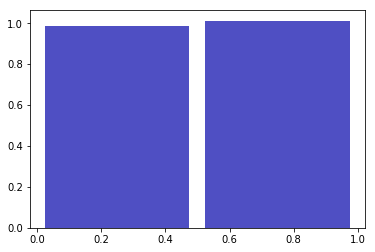

In [69]:
batch = list(exp_replay.sample_batch(500))
acts = np.asarray(batch[1])
plt.hist(x=acts, bins=env.action_space.n, color='#0504aa', density=True,
                            alpha=0.7, rwidth=0.9)

In [12]:
# Teste l'efficacite d'un modele
with tf.Session(graph=graph) as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    saver.restore(sess, './models/best-model')
    R = np.array([runGame(env, q_net) for _ in range(10)])
    print(R)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/best-model
[[ 318. 5218.]
 [ 401. 6391.]
 [ 401. 6391.]
 [ 401. 6391.]
 [ 114. 2303.]
 [ 149. 2803.]
 [ 205. 3603.]
 [ 117. 2346.]
 [ 115. 2318.]
 [ 108. 2218.]]


INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-10000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-20000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-30000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-40000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-50000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-60000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-70000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-80000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-90000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-100000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-110000
INFO:tensorflow:Restoring parameters from ./models/test-net-128-128-64-relu-120000
INFO:tensorfl

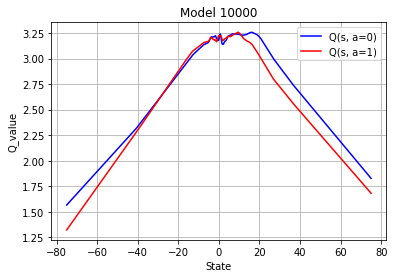

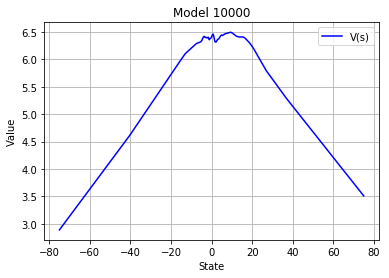

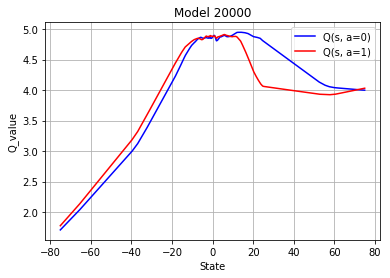

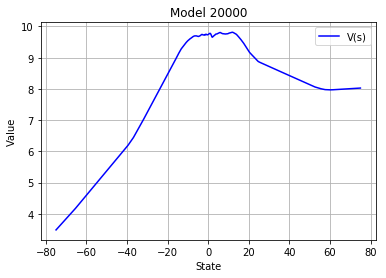

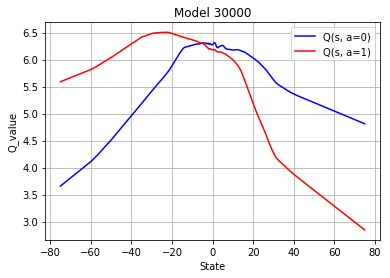

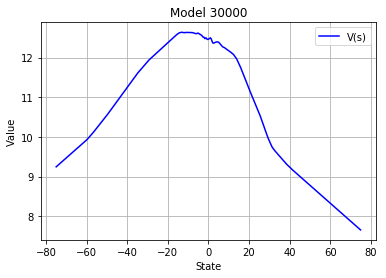

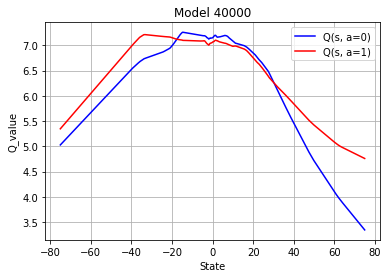

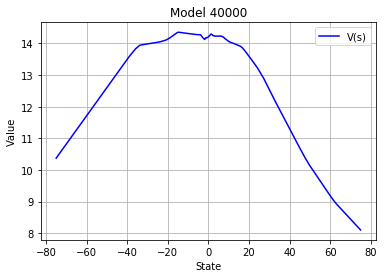

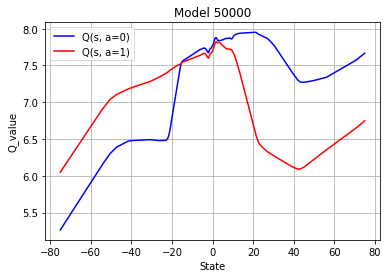

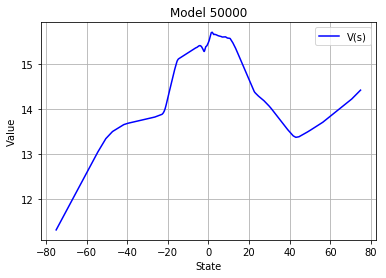

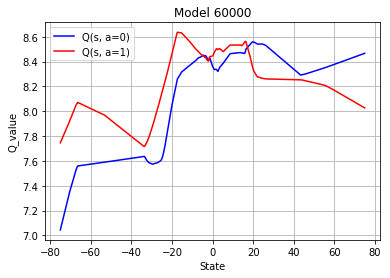

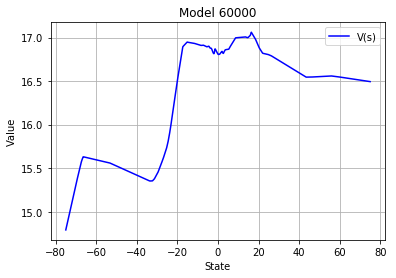

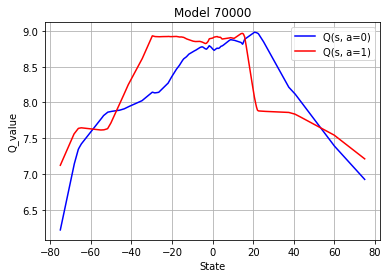

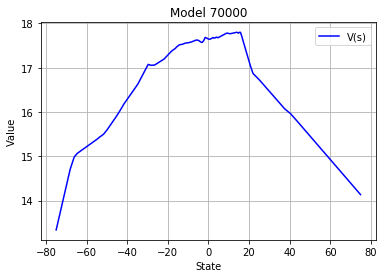

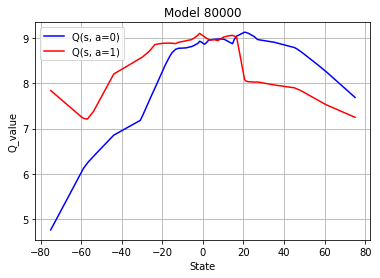

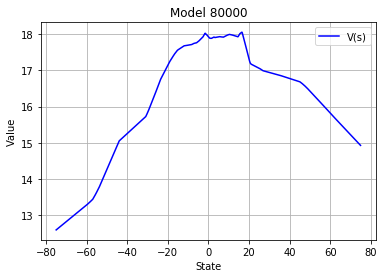

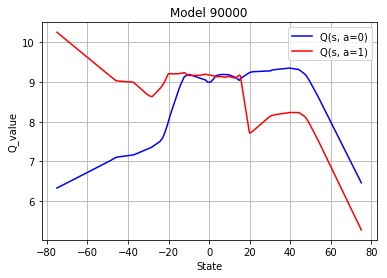

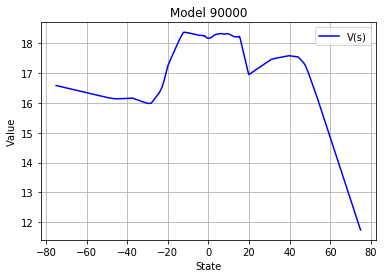

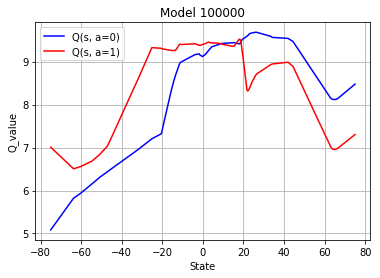

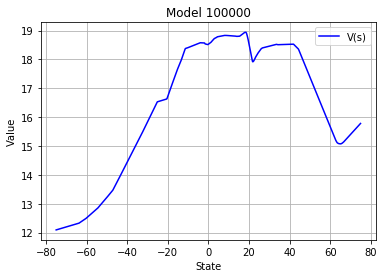

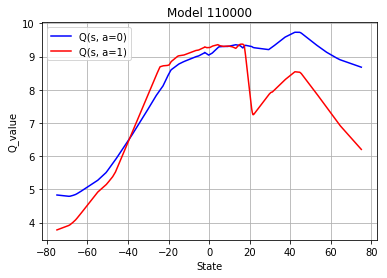

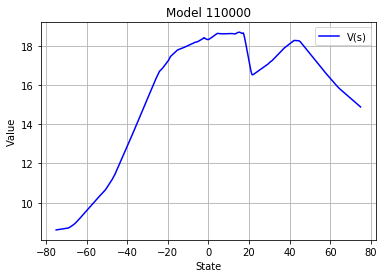

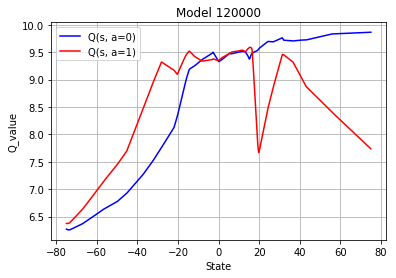

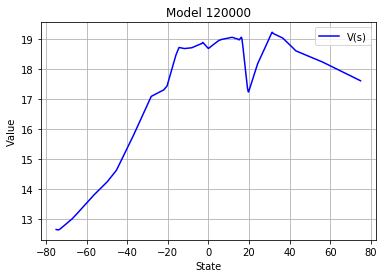

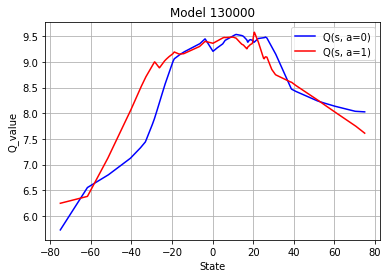

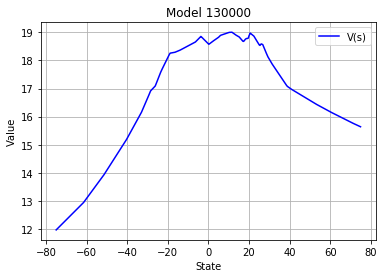

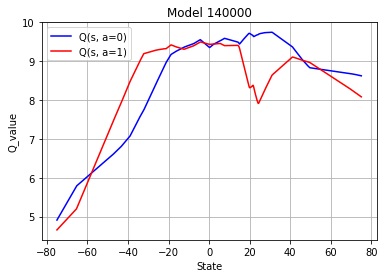

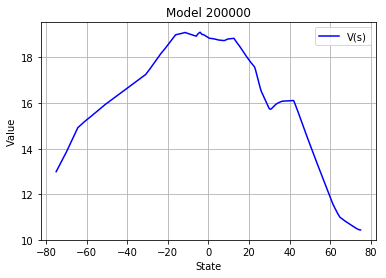

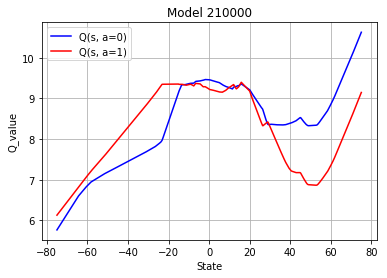

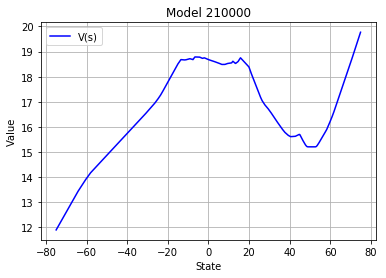

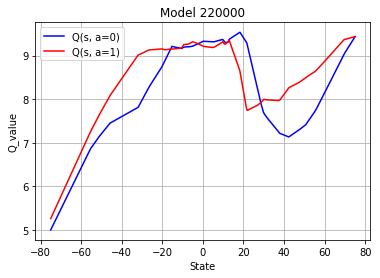

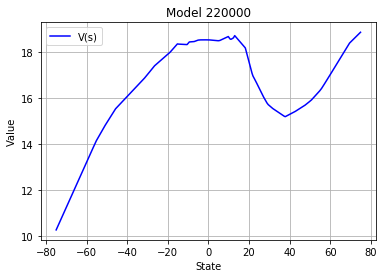

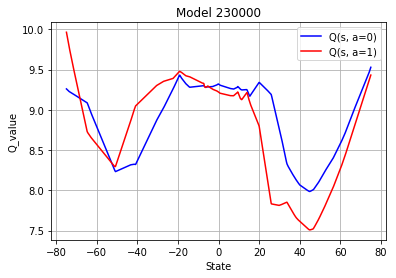

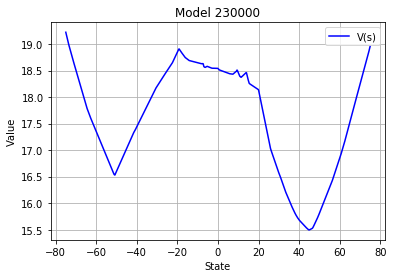

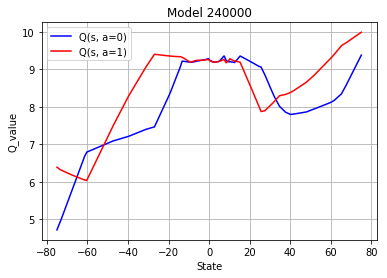

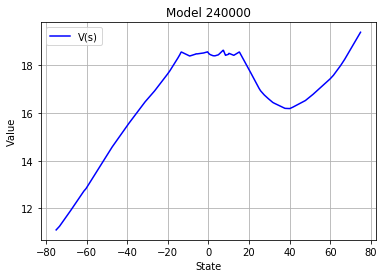

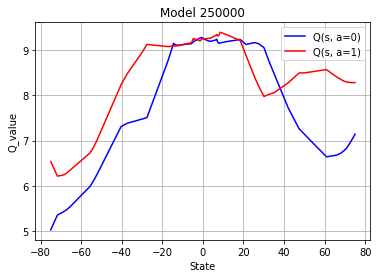

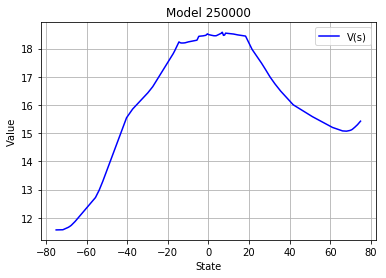

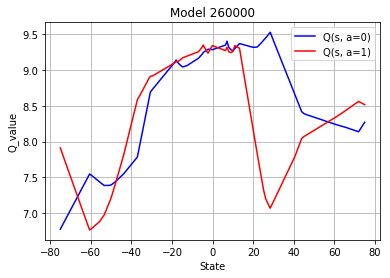

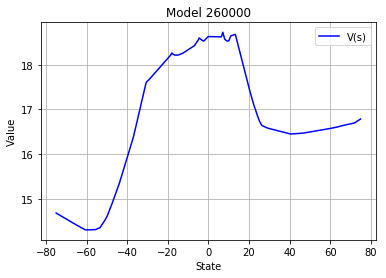

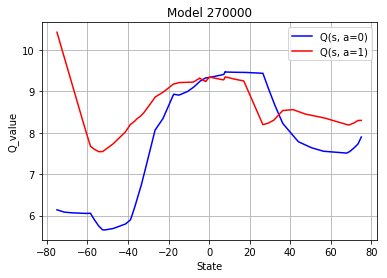

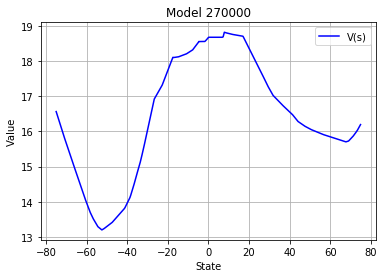

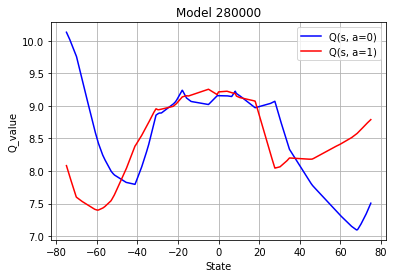

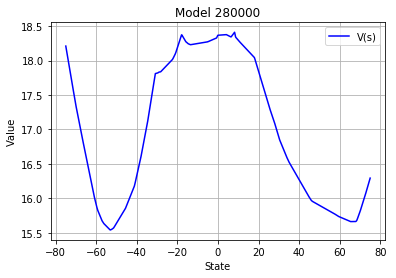

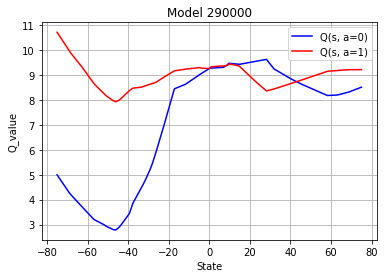

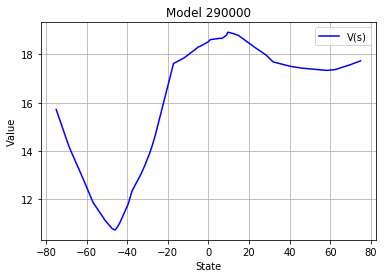

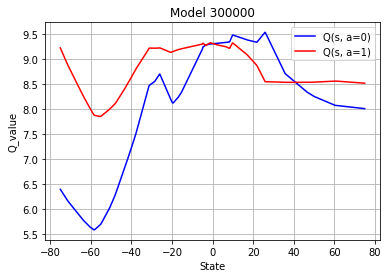

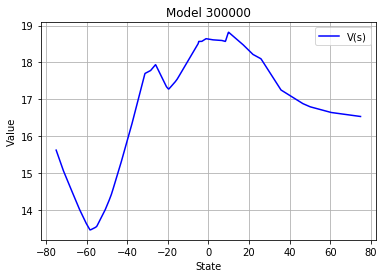

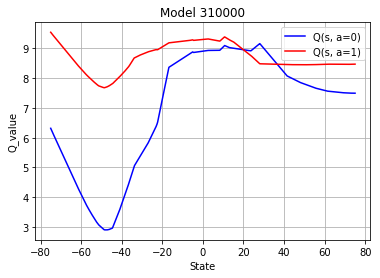

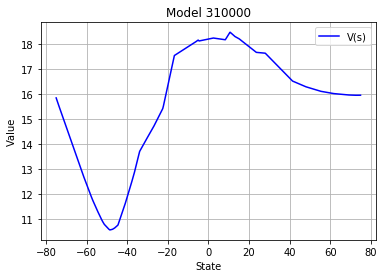

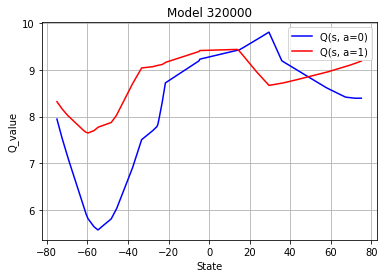

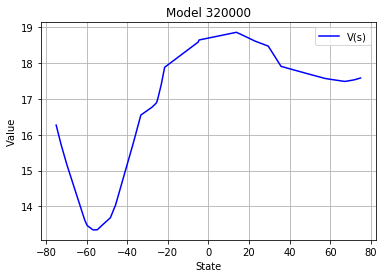

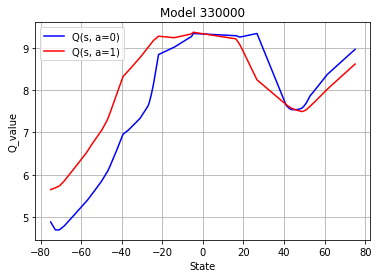

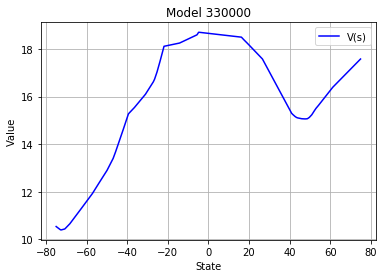

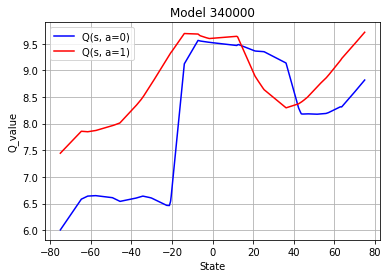

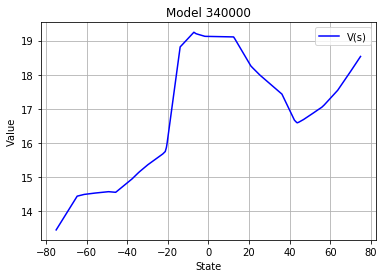

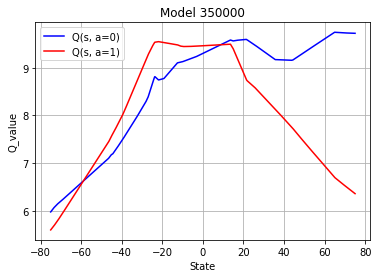

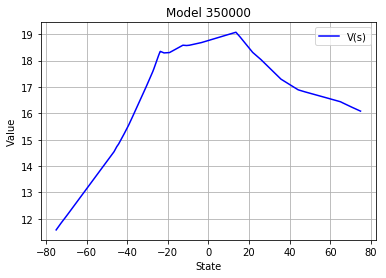

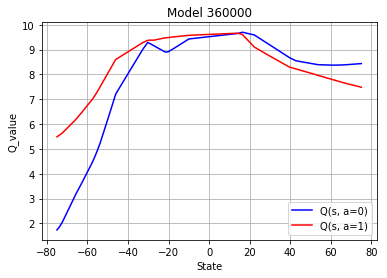

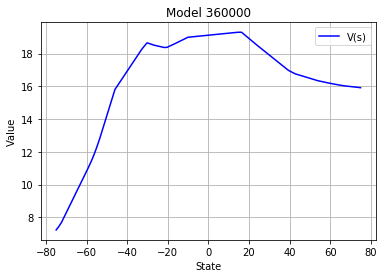

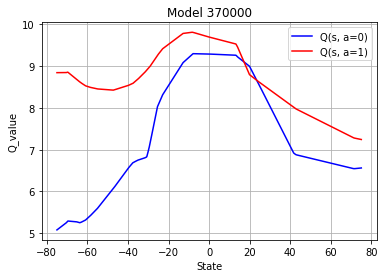

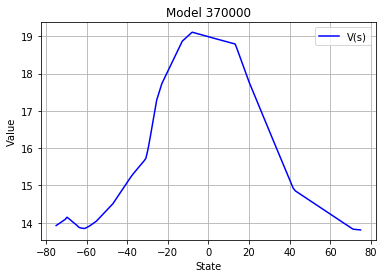

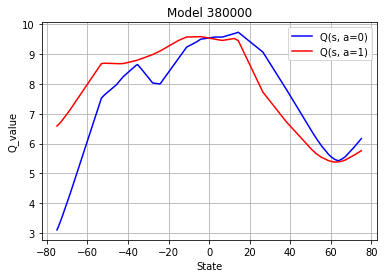

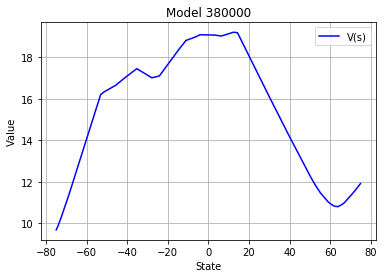

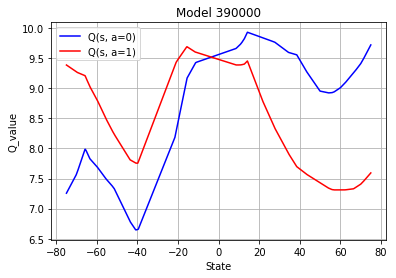

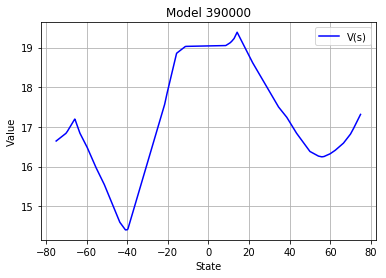

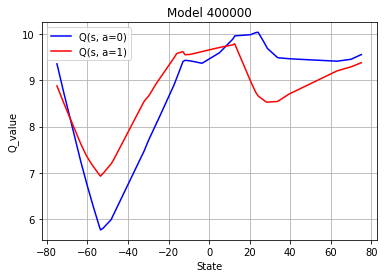

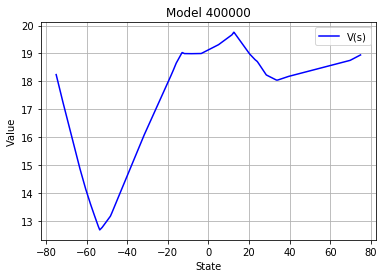

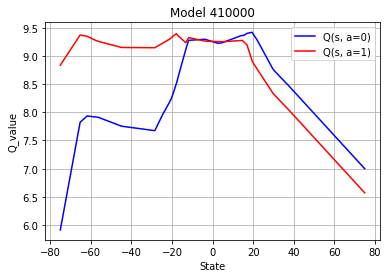

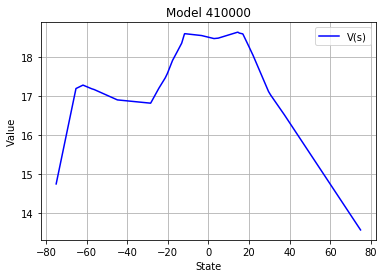

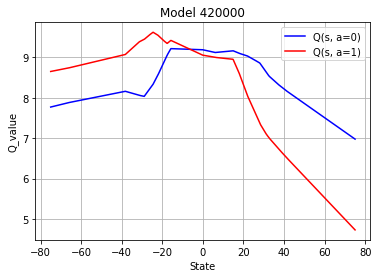

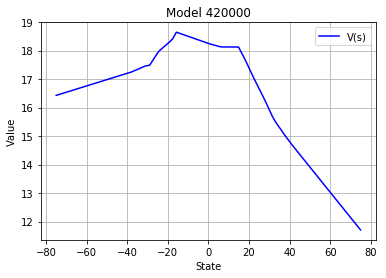

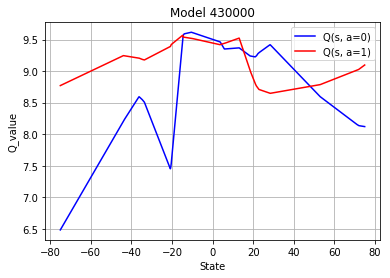

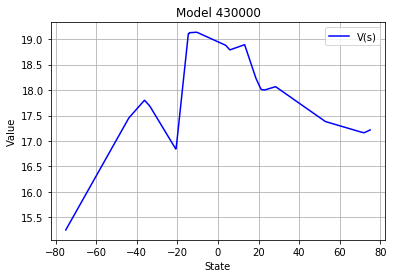

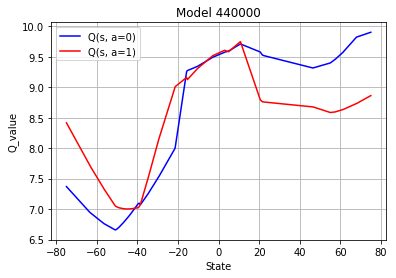

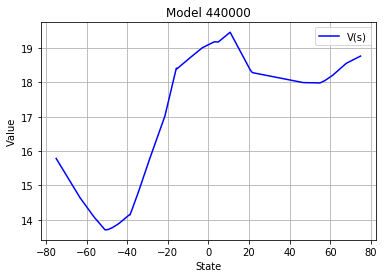

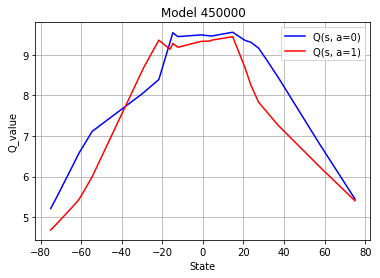

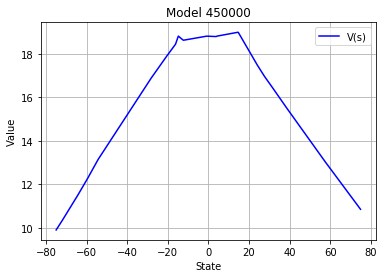

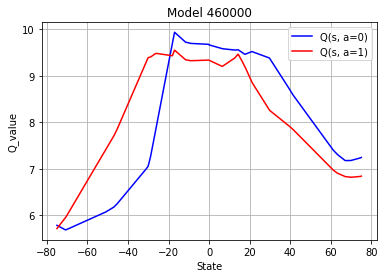

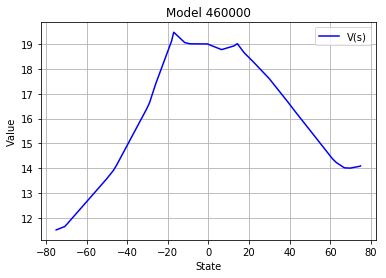

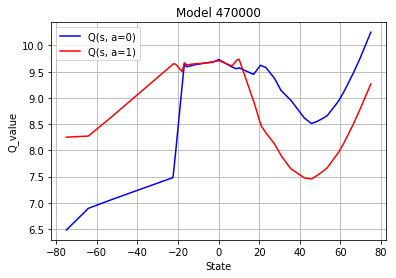

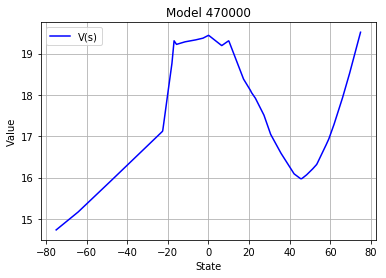

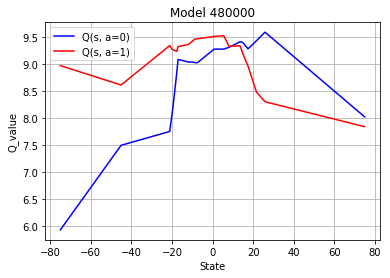

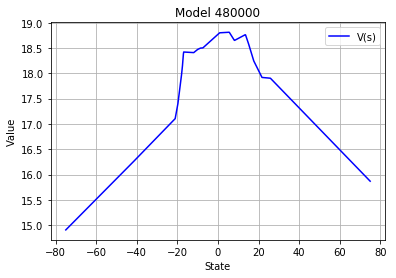

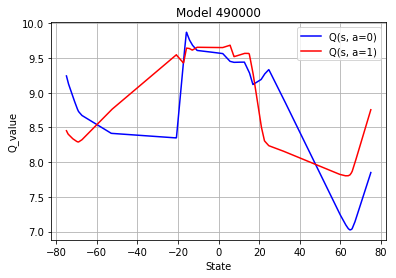

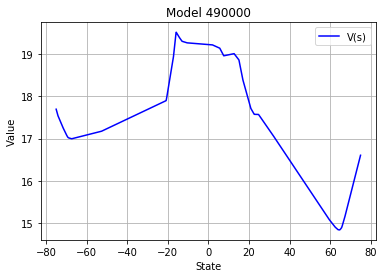

In [41]:
# Display saved models
n_models=500000
save_gap = 20000
with tf.Session(graph=graph) as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    for i, num_model in enumerate(range(save_gap,n_models,save_gap)):
        saver.restore(sess, './models/{}-{}'.format(model_name,num_model))
        dy = np.linspace(-75,75, 1000)#np.arange(-75,75)
        dy.shape = (dy.size,1)
        value = sess.run(q_net.q_out, feed_dict={q_net.inputs:dy})
        rew = np.array([runGame(env, q_net) for _ in range(15)])
        mean_score, mean_rew = rew[:,0].mean(), rew[:,1].mean()
        display_Q(dy,value[:,0],value[:,1],'Model after {} steps - Rew {}/Score {}'.format(num_model,mean_rew, mean_score),i, save_name='Qvalue-{}-{}'.format(model_name, num_model) )
        display_V(dy,value[:,0]+value[:,1],'Model after {} steps - Rew {}/Score {}'.format(num_model,mean_rew, mean_score),i, save_name='Value-{}-{}'.format(model_name, num_model) )

In [129]:
with tf.Session(graph=graph) as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('./models/'))
    saver.restore(sess, './models/model-cnn-650')
    
    done = False
    obs = env.reset()
    it=0
    while not done:
        it+=1
        [action], [value] = sess.run([q_net.predict, q_net.q_out], feed_dict={q_net.inputs:[obs]})
        #print(action, value)
        if (it%50==0):
            pass#displayEnv(env, it)
            
        obs, rew, done, info = env.step(action)
    print("Score final ", env.score, it)

INFO:tensorflow:Restoring parameters from ./models/model-cnn-650
Score final  11 445


INFO:tensorflow:Restoring parameters from ./models/model-cnn-1100


<Figure size 432x288 with 0 Axes>

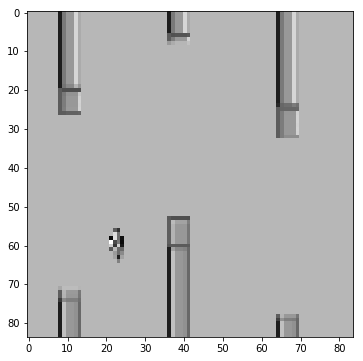

[[ 13. 514.]
 [ 16. 572.]
 [ 16. 589.]
 [ 26. 839.]
 [ 11. 464.]
 [ 10. 438.]
 [ 10. 441.]
 [ 18. 639.]
 [ 14. 519.]
 [  7. 312.]
 [ 14. 521.]
 [ 15. 564.]
 [ 16. 589.]
 [ 14. 542.]
 [ 12. 489.]]
INFO:tensorflow:Restoring parameters from ./models/test-0
[[ 18. 639.]
 [ 10. 410.]
 [ 17. 614.]
 [  9. 405.]
 [ 28. 889.]
 [ 15. 547.]
 [ 14. 539.]
 [  2. 148.]
 [ 13. 514.]
 [ 16. 589.]
 [ 14. 539.]
 [ 16. 589.]
 [ 21. 714.]
 [ 11. 464.]
 [ 16. 589.]]


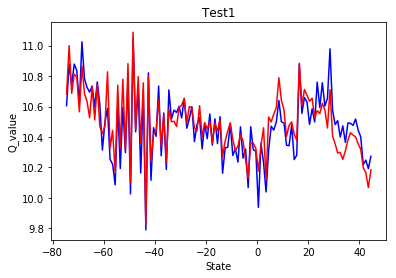

In [16]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, './models/model-cnn-1100')
    global_step = 1150
    
    done = False
    obs = env.reset()
    it=0
    while it < 90:
        it+=1
        [action], [value] = sess.run([q_net.predict, q_net.q_out], feed_dict={q_net.inputs:[obs]})
        obs, rew, done, info = env.step(action)

    displayEnv(env, 0)
    
    R = np.array([runGame(env, q_net) for _ in range(15)])
    print(R)
    
    env = FlappyBirdCnnEnv()
    obs = env.reset()
    while exp_replay.burn_in_capacity() < 1:
        action = env.action_space.sample()
        #[action] = sess.run(q_net.predict, feed_dict={q_net.inputs:[obs]})
        obs1, reward, done, _ = env2.step(action)

        error = sess.run(dqn_model.error, feed_dict={dqn_model.states:[obs],
                                                     dqn_model.states_next:[obs1], 
                                                     dqn_model.actions:[action], 
                                                     dqn_model.rewards:[reward],
                                                     dqn_model.done_flags:[done]})
        exp_replay.append(error, obs, action, reward, done, obs1)
        obs = obs1

    
    dy, v0, v1 = testValue(sess, q_net, env)
    displayCurve(dy, v0,v1, 'Test1', 1)
    saver.save(sess, "./models/test", global_step=0)

with tf.Session(graph=graph) as sess:
    saver.restore(sess, './models/test-0')
    #dy, v0, v1 = testValue(sess, q_net, env)
    #displayCurve(dy, v0,v1, 'Test2', 2)
    
    R = np.array([runGame(env, q_net) for _ in range(15)])
    print(R)


INFO:tensorflow:Restoring parameters from ./models/test-full-image-1
INFO:tensorflow:Restoring parameters from ./models/test-full-image-2


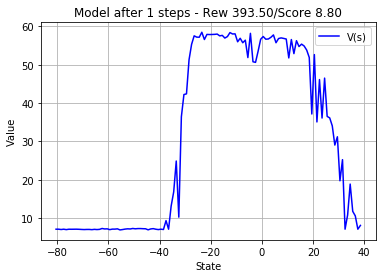

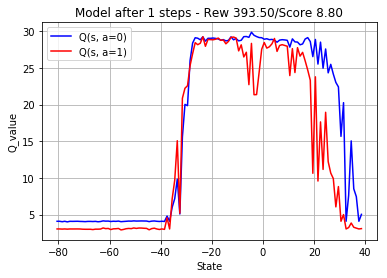

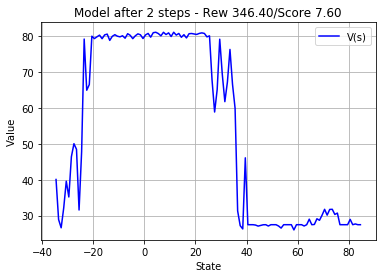

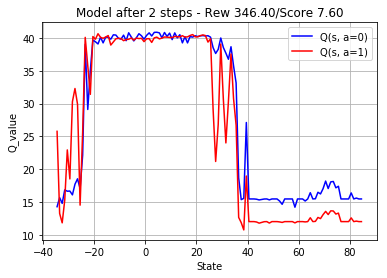

In [37]:
n_models=3
save_gap = 1
with tf.Session(graph=graph) as sess:
    for num, num_model in enumerate(range(save_gap,n_models,save_gap)):
        saver.restore(sess, './models/{}-{}'.format(model_name,num_model))
        eval_display_policy(sess, FlappyBirdCnnEnv, num_model, num, save_name="{}-{}".format(model_name, num_model))

## 2) Behavior Cloning Algorithm

### BC Paramétrage

In [ ]:
n_epochs = 3
batch_size = 16
freq_st_log = 10
freq_ep_log = 1
freq_ep_save = 1
n_ep_test = 10

### Modèle et entrainement

In [8]:
class BehaviorCloningModel:
    def __init__(self, q_net, lr=0.001):
        self.inputs = net.inputs
        self.net = net.q_out
        self.learning_rate = lr
        self.net.shape
        self.expert_out = tf.placeholder(shape=[None, 2], dtype=tf.float32)
        
        self.loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.expert_out, logits=self.net), name="loss_cross_entrop_bc")
        #self.loss = tf.reduce_sum(tf.square(self.expert_out - self.net))
        
        trainer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.optim = trainer.minimize(self.loss, name="adam_optim")

In [ ]:
restore=True
c_rew = []
with graph.as_default():
    bc = BehaviorCloning(q_net, lr=learning_rate)

print("Start Behavior Cloning")
with tf.Session(graph=graph) as sess:
    if restore:
        sess.run(tf.global_variables_initializer())
        global_step = 0
    else:
        print("No restore")
        #saver.restore(sess, tf.train.latest_checkpoint('./'))
        #saver.restore(sess, 'model-10')
        
    num_batches = int(len(data['obs'])/batch_size)
    print('Nombre batches : ', num_batches)
  
    for epoch in range(global_step, n_epochs):
        #np.random.shuffle(data)
        for step in range(num_batches):
            clone_obs, clone_action = getNextBatch(data, batch_size, step)
            loss, _ = sess.run([bc.loss, bc.optim], 
                                        feed_dict={ bc.inputs: clone_obs,
                                                    bc.expert_out : clone_action
                                                    })
            if step%freq_st_log==0:
                print('Ep {}/{} - [step {}/{}] --- Loss={}'.format(epoch+1, n_epochs, step+1, num_batches, loss))
            if step%100==0:
                R = np.array([runGame(env, q_net) for _ in range(n_ep_test)])
                print('Score={}, Mean={}'.format(R, R.mean()))
                #c_rew = np.append(c_rew, R.mean())
        if epoch%1==0:
            R = np.array([runGame(env, q_net)[0] for _ in range(n_ep_test)])
            print('Score={}, Mean={}'.format(R, R[0].mean()))
        if epoch%freq_ep_save == 0 :
            print("Saving model")
            saver.save(sess, "./models/model", global_step=global_step)

        global_step = global_step + 1

### Tests and Results

In [18]:
print(c_rew)

[106. 211. 138. 185. 401. 361. 401. 334. 122. 123. 120. 242. 127.  95.
 326. 177.  82. 341. 145. 324.]


In [ ]:
with tf.Session(graph=graph) as sess:
    t_vars = tf.trainable_variables()
    print(t_vars)
    R = np.array([runGame(env, q_net) for _ in range(n_ep_test)])
    print('Score Mean', R.mean())

### Processing Data Expert

In [12]:
dataset_name = 'dqn-expert.npz'
dataset_save = 'dqn-expert.npz'

In [13]:
def load(dataset_name):
    try:
        print('Load Dataset ', dataset_name)
        clone = {}
        trajs = np.load(dataset_name)
        for key in trajs.files:
            print(key , trajs[key].shape)
            clone[key] = trajs[key]
    except FileNotFoundError:
        print('Dataset Not found -> New Dataset created')
        clone = { 'actions': np.empty(shape=[0, 1]),
                  'obs': np.empty(shape=[0] + list(env.observation_space.shape) ),
                  'episode_starts': np.empty(shape=[0, 1], dtype=bool),
                  'episode_returns': np.empty(shape=[0, 1])}
    return clone

In [14]:
data = load(dataset_name)

Load Dataset  dqn-expert.npz
obs (1122934, 1)
episode_returns (296, 1)
episode_starts (1122934, 1)
actions (1122933, 1)


In [15]:
def getNextBatch(data, batch_size, step):
    act = np.empty(shape=[0,2])
    for action in data['actions'][step*batch_size:step*batch_size + batch_size]:
        val = np.zeros((2))
        val[int(action)] = 1
        act = np.append(act, [val], axis=0)
    return data['obs'][step*batch_size:step*batch_size + batch_size], act

### Create Expert Trajectories

In [29]:
n_episode = 300
freq_log = 150

In [30]:
env = FlappyBirdEnv()
l_score = []

In [ ]:
sum_score = 0
for i_episode in range(n_episode):
    obs = env.reset()
    t_rew = 0
    while True:
        action = 0 if obs > 0 else 1
        #print('Save traj [o {}, a {}]'.format(obs, action))
        obs, reward, done, info = env.step(action)
        t_rew += reward
        values = {'actions':action, 'obs':[obs], 'episode_starts':done}
        for key, val in values.items():
            if key == 'obs':
                data[key] = np.append(data[key], [val], axis=0)
            else:
                data[key] = np.append(data[key], [[val]], axis=0)
        if done:
            break
    sum_score += env.score
    data['episode_returns'] = np.append(data['episode_returns'], [[t_rew]], axis=0)
    l_score = l_score + [env.score]
    if i_episode%freq_log==0:
        print("[Ep {}/{}] Mean Score {} episodes : {}".format(i_episode, n_episode,freq_log,sum_score/freq_log))
        sum_score = 0
            

env.close()

[Ep 0/3000] Mean Score 150 episodes : 0.52
[Ep 150/3000] Mean Score 150 episodes : 210.56666666666666


In [10]:
np.savez(dataset_save, actions=data['actions'], obs=data['obs'],
                     episode_returns=data['episode_returns'], episode_starts=data['episode_starts'])

(296, 1)
Mean=3785.625, Std=1598.0854776370566


/home/jupyter/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 50.0)

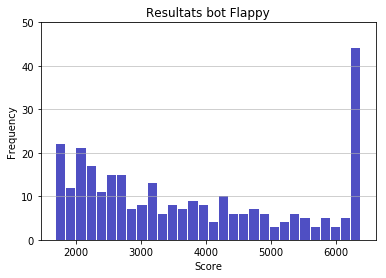

In [14]:
import matplotlib.pyplot as plt
l_score = data['episode_returns']#np.array(l_score)

print(l_score.shape)
print('Mean={}, Std={}'.format(l_score.mean(), l_score.std()))

n, bins, patches = plt.hist(x=l_score, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Resultats bot Flappy')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
